# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, recall_score, precision_score

# Load Data

In [2]:
df = pd.read_csv('creditcard.csv')

# Exploratory Data Analysis (EDA)

In [3]:
print("Data Info:")
df.info()
print("Missing Values:")
print(df.isnull().sum())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21 

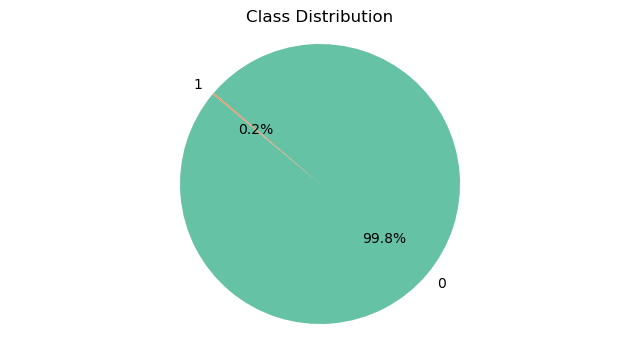

In [4]:
# Visualizing Class Distribution
class_counts = df['Class'].value_counts()
plt.figure(figsize=(8, 4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62'])
plt.title("Class Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

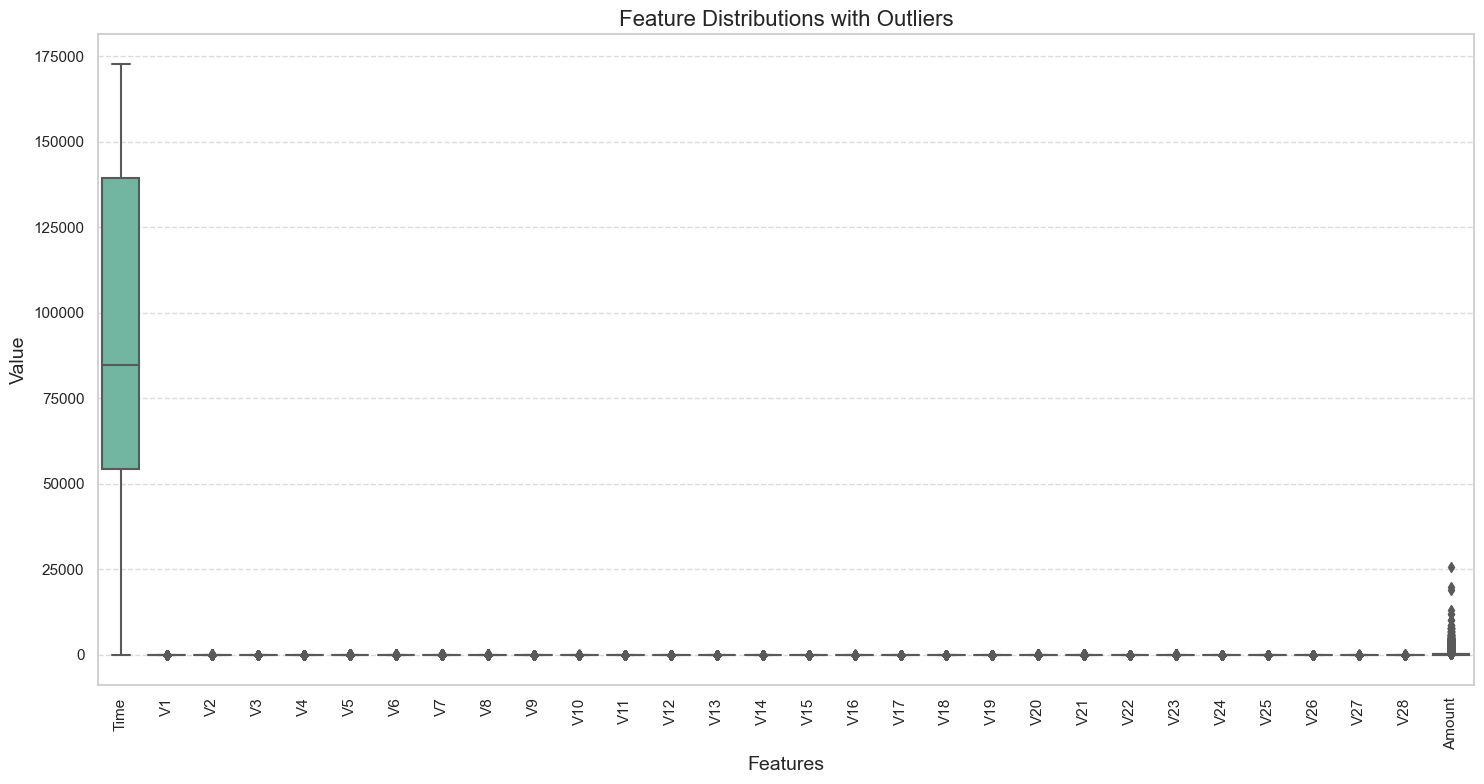

In [5]:
# Feature distribution visualization
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))
sns.boxplot(data=df.drop(columns=['Class']), palette="Set2", fliersize=5)
plt.xticks(rotation=90)
plt.title("Feature Distributions with Outliers", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

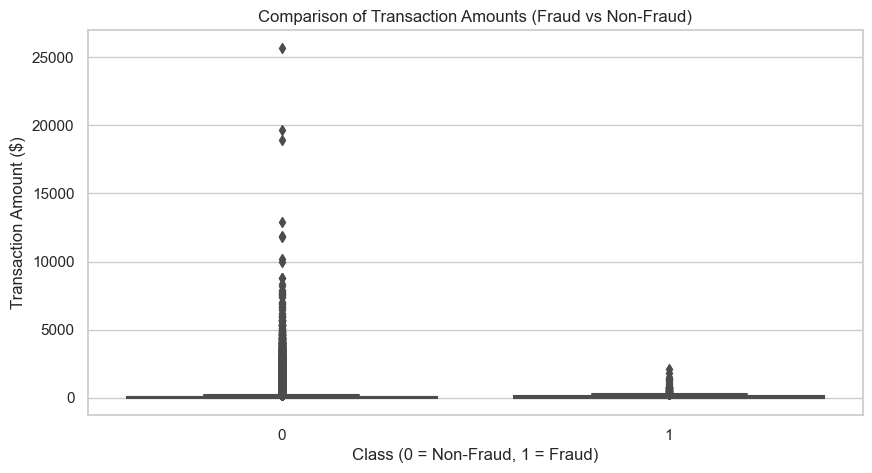

In [6]:
# Compare Transaction Amounts by Class
plt.figure(figsize=(10, 5))
sns.boxplot(x="Class", y="Amount", data=df)
plt.title("Comparison of Transaction Amounts (Fraud vs Non-Fraud)")
plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Transaction Amount ($)")
plt.show()

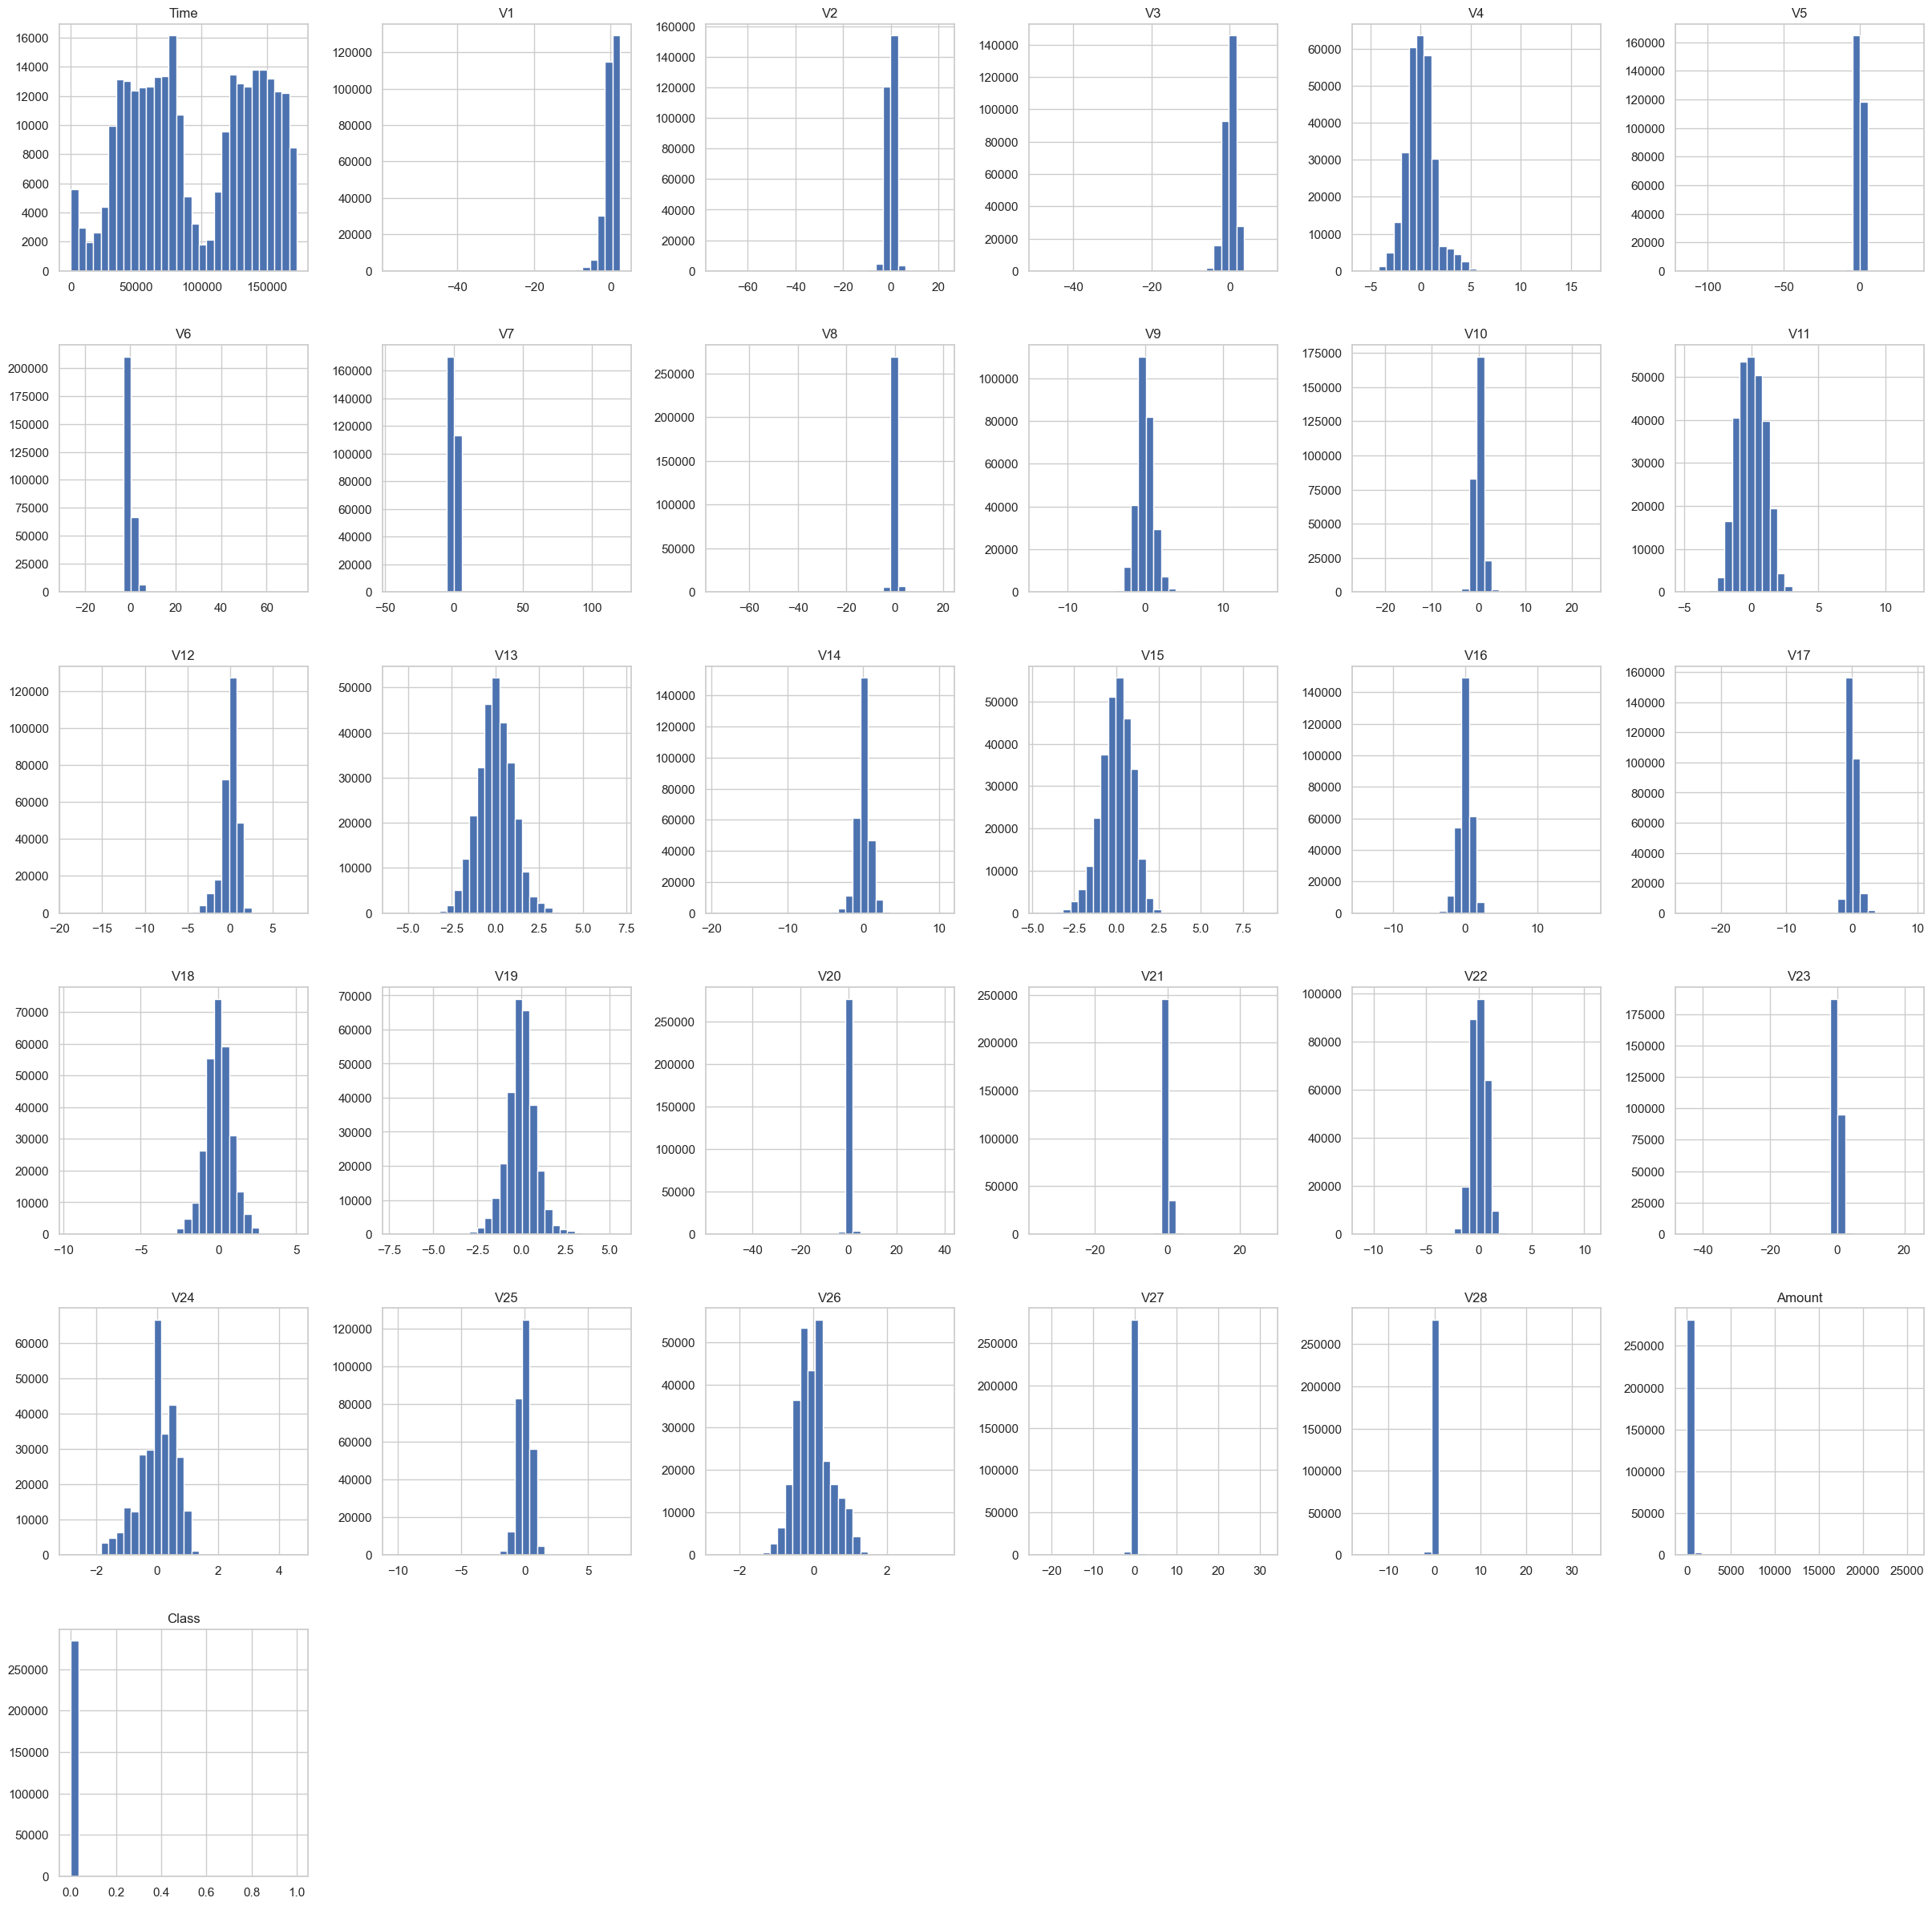

In [7]:
# Histogram of features
df.hist(bins=30, figsize=(30,30))
plt.show()

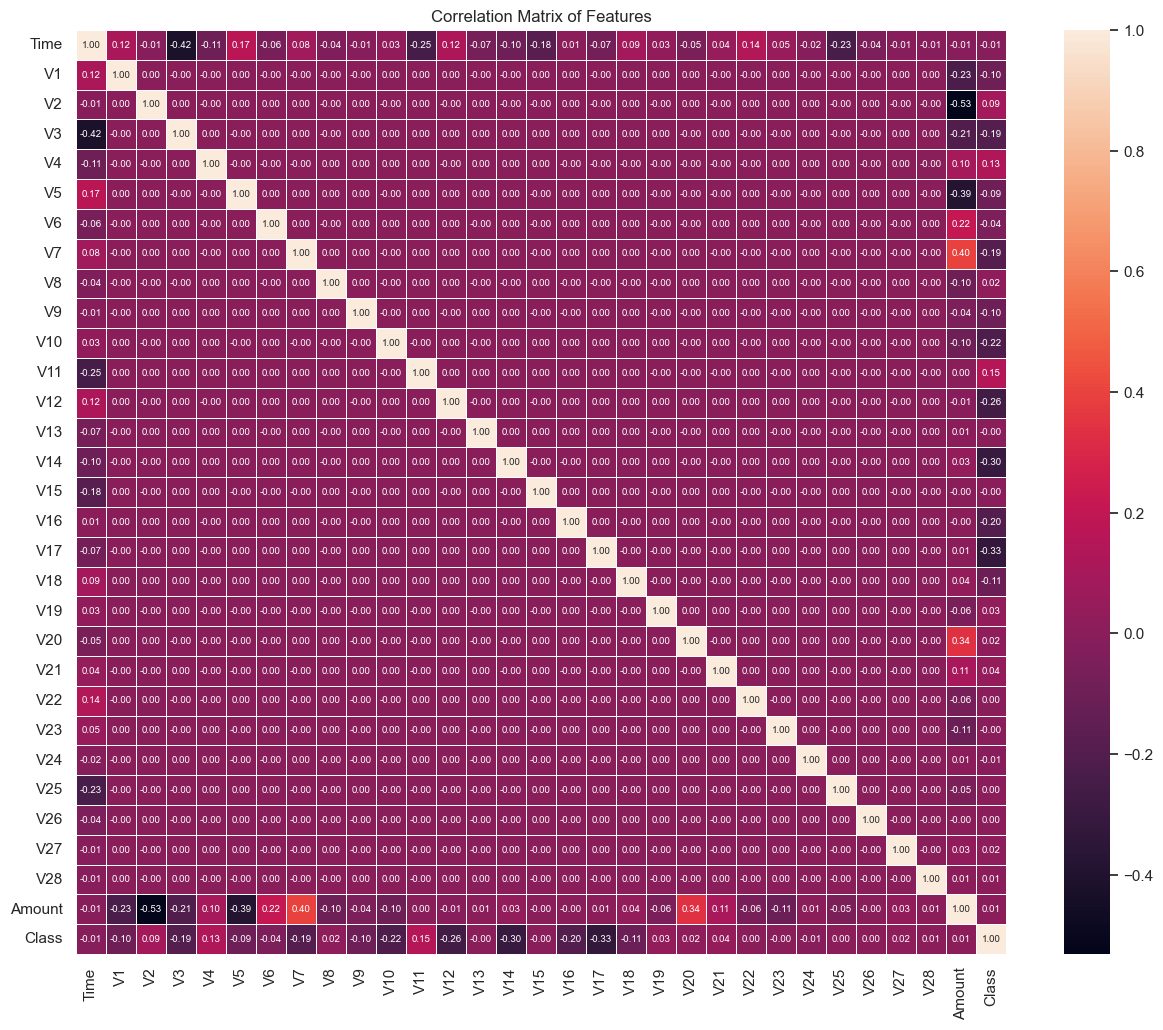

In [8]:
# Plot the Heatmap
plt.figure(figsize=(15,12))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths=0.5, annot_kws={"size":7})
plt.title('Correlation Matrix of Features')
plt.show()

# Handling Missing Values

In [9]:
# Fill missing values with the median of each column
df.fillna(df.median(), inplace=True)

# Feature Engineering & Data Transformation

In [10]:
# Standardize 'Amount' and 'Time'
scaler = StandardScaler()
df[['Amount', 'Time']] = scaler.fit_transform(df[['Amount', 'Time']])

# Handling Imbalanced Data with SMOTE

In [11]:
X = df.drop(columns=['Class'])
y = df['Class']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Feature Selection using SelectKBest

In [12]:
selector = SelectKBest(f_classif, k=20)  # Selecting top 20 features
X_selected = selector.fit_transform(X_resampled, y_resampled)

# Train/Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Model Training & Hyperparameter Tuning

In [14]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 15],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

best_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=2, scoring='roc_auc', n_iter=3, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)
print(f"Best Random Forest Params: {best_rf.best_params_}")

/Users/pallabbhandari/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=3. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Random Forest Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 15}


# Train Model with Best RandomForest Parameters

In [15]:
rf_model = RandomForestClassifier(**best_rf.best_params_, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, random_state=42)

# Model Evaluation

In [16]:
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9989
Precision: 0.9991
Recall: 0.9987
F1-score: 0.9989


# Confusion Matrix

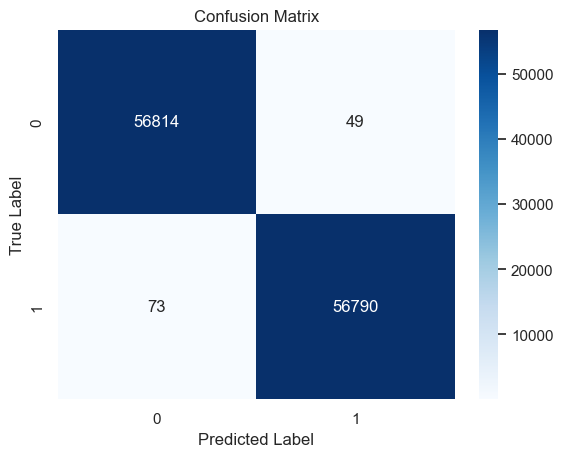

In [17]:
cm = confusion_matrix(y_test, y_pred)
labels = ["0", "1"]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Save the Best Model

In [18]:
joblib.dump(rf_model, "credit_card_model.pkl")

['credit_card_model.pkl']

# Download and save the model

In [19]:
# path of the Downloads folder
download_path = "/Users/pallabbhandari/Downloads/credit_card_model.pkl"

# Save the model
joblib.dump(rf_model, download_path)

print(f"Model saved at: {download_path}")

Model saved at: /Users/pallabbhandari/Downloads/credit_card_model.pkl


# Load and Predict

In [20]:
test_model = joblib.load("credit_card_model.pkl")
new_sample = np.random.rand(1, X_train.shape[1])
y_pred = test_model.predict(new_sample)
print("Fraud Transaction" if y_pred == 1 else "Normal Transaction")

Normal Transaction
